# Results Visualization

Analysis of ML experiment results for predicting LLM answer correctness.

## Notebook Structure:

1. **LODO Results** - RF filter performance per dataset (baseline vs filtered accuracy)
2. **Per-Model Feature Analysis** - Which features are important AND stable for each model
3. **Cross-Model Comparison** - Overall performance metrics across models
4. **Coverage vs Accuracy** - Trade-off analysis per dataset
5. **Cross-Model Feature Analysis** - Which features are **generalizing** (important across ALL models)
6. **Calibration Analysis** - ECE comparison: LLM raw confidence vs RF classifier

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from results.experiment_saver import ExperimentLoader

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [74]:
# Load all experiments
loader = ExperimentLoader()

print("Available models:")
for model in loader.list_models():
    experiments = loader.list_experiments(model)
    print(f"  {model}: {len(experiments)} experiments")
    for exp in experiments[:3]:  # Show last 3
        print(f"    - {exp}")

Available models:
  deepseek-ai_DeepSeek-R1-Distill-Qwen-32B: 1 experiments
    - 2025-11-28_11-15-56
  openai_gpt-oss-120b: 1 experiments
    - 2025-11-28_11-31-02


In [75]:
# Load latest experiment for each model
all_experiments = loader.load_all_latest()
print(f"Loaded {len(all_experiments)} experiments")

Loaded 2 experiments


---
# 1. LODO Results: RF Filter Performance

**What it shows:** For each held-out dataset, compares:
- **Baseline** = LLM accuracy without filter (always responds)
- **Filtered** = accuracy when RF predicts "correct" (responds only when confident)
- **Coverage** = % of questions answered
- **Gain** = accuracy improvement (Filtered - Baseline)

> A good filter has **high Gain** while maintaining **acceptable coverage**

In [76]:
# Create comparison table for each model
for exp in all_experiments:
    if 'lodo_results' not in exp:
        continue
    
    model = exp['model']
    timestamp = exp['timestamp']
    df = pd.DataFrame(exp['lodo_results'])
    
    print(f"\n{'='*70}")
    print(f"Model: {model}")
    print(f"Timestamp: {timestamp}")
    print(f"{'='*70}")
    
    # Format table
    display_df = df[['Dataset', 'N', 'Baseline', 'Coverage', 'Filtered_Acc', 'Gain']].copy()
    display_df['Baseline'] = display_df['Baseline'].map(lambda x: f"{x:.1%}")
    display_df['Coverage'] = display_df['Coverage'].map(lambda x: f"{x:.1%}")
    display_df['Filtered_Acc'] = display_df['Filtered_Acc'].map(lambda x: f"{x:.1%}")
    display_df['Gain'] = display_df['Gain'].map(lambda x: f"{x:+.1%}")
    
    print(display_df.to_string(index=False))
    
    # Aggregates
    if 'meta' in exp:
        meta = exp['meta']
        print(f"\nWeighted Averages:")
        print(f"  Baseline:  {meta.get('weighted_baseline', 'N/A'):.1%}")
        print(f"  Filtered:  {meta.get('weighted_filtered', 'N/A'):.1%}")
        print(f"  Gain:      {meta.get('weighted_gain', 'N/A'):+.1%}")
        print(f"  Coverage:  {meta.get('weighted_coverage', 'N/A'):.1%}")


Model: deepseek-ai_DeepSeek-R1-Distill-Qwen-32B
Timestamp: 2025-11-28_11-15-56
     Dataset     N Baseline Coverage Filtered_Acc   Gain
       MedQA 12684    77.9%    39.2%        90.3% +12.4%
   AfrimedQA   174    71.3%    63.2%        78.2%  +6.9%
  MedBullets   295    59.7%    49.5%        71.2% +11.6%
     MedExQA   935    81.0%    80.4%        86.6%  +5.6%
     MedMCQA  2816    67.2%    71.0%        76.1%  +9.0%
MedXpertQA-R  1835    18.4%    26.4%        20.0%  +1.7%
MedXpertQA-U   585    21.2%    23.1%        25.9%  +4.7%
    MMLU-Pro   312    63.1%    54.8%        77.2% +14.1%
        MMLU   648    92.9%    80.2%        96.5%  +3.6%
    PubMedQA   500    75.0%    83.2%        79.8%  +4.8%

Weighted Averages:
  Baseline:  69.6%
  Filtered:  79.6%
  Gain:      +10.0%
  Coverage:  46.7%

Model: openai_gpt-oss-120b
Timestamp: 2025-11-28_11-31-02
     Dataset     N Baseline Coverage Filtered_Acc   Gain
       MedQA 12683    92.2%    69.4%        96.3%  +4.1%
   AfrimedQA   174    7

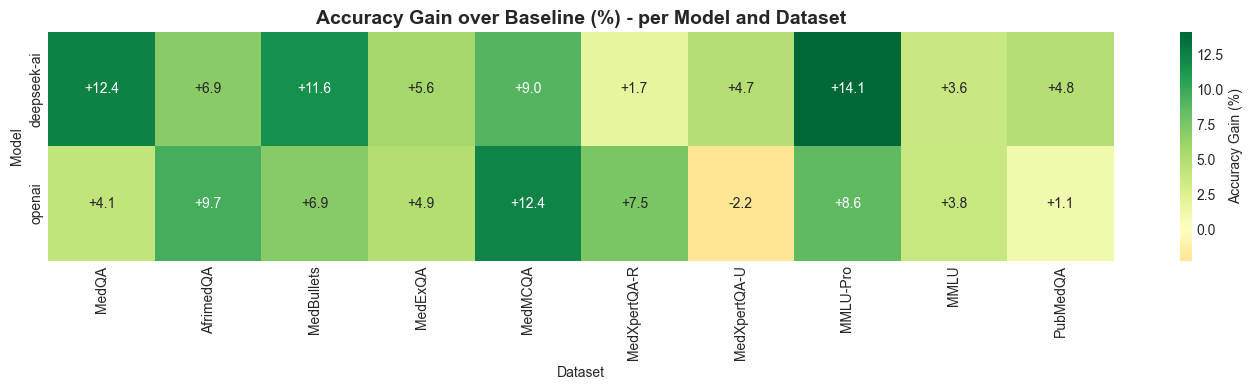

In [77]:
# Heatmap: Gain per dataset per model
if len(all_experiments) > 0:
    # Build matrix
    data = {}
    for exp in all_experiments:
        if 'lodo_results' not in exp:
            continue
        model = exp['model'].split('_')[0]  # Short name
        for row in exp['lodo_results']:
            if model not in data:
                data[model] = {}
            data[model][row['Dataset']] = row['Gain']
    
    if data:
        gain_df = pd.DataFrame(data).T
        
        fig, ax = plt.subplots(figsize=(14, max(4, len(gain_df) * 0.8)))
        sns.heatmap(
            gain_df * 100,  # Convert to percentage
            annot=True, 
            fmt='+.1f',
            cmap='RdYlGn',
            center=0,
            cbar_kws={'label': 'Accuracy Gain (%)'},
            ax=ax
        )
        ax.set_title('Accuracy Gain over Baseline (%) - per Model and Dataset', fontsize=14, fontweight='bold')
        ax.set_xlabel('Dataset')
        ax.set_ylabel('Model')
        plt.tight_layout()
        plt.show()

---
# 2. Per-Model Feature Analysis

**What it shows:** For each LLM model, a unified view of features with:
- **SHAP Importance** = how much the feature influences predictions (mean across folds)
- **Folds** = in how many LODO folds the feature was selected (stability)
- **Stability %** = percentage of folds survived

> A **robust** feature has both high SHAP importance AND high stability (appears in many folds)


MODEL: deepseek-ai_DeepSeek-R1-Distill-Qwen-32B

Top 25 Features by SHAP Importance (with Fold Stability):
--------------------------------------------------------------------------------
                    Feature    Category     SHAP Folds Stability
   fast_vocabulary_richness Text (Fast) 0.025898 10/10      100%
           reasoning_length    Log-Prob 0.025798 10/10      100%
entropy_max_decrease_streak    Log-Prob 0.023513 10/10      100%
      reasoning_avg_entropy    Log-Prob 0.023076 10/10      100%
           fast_hedge_ratio Text (Fast) 0.018407 10/10      100%
                 margin_end    Log-Prob 0.014916  9/10       90%
                entropy_end    Log-Prob 0.014558  9/10       90%
     fast_vocab_growth_rate Text (Fast) 0.013102  9/10       90%
            margin_max_drop    Log-Prob 0.012117 10/10      100%
      reasoning_min_entropy    Log-Prob 0.011548 10/10      100%
       reasoning_avg_margin    Log-Prob 0.011327  0/10        0%
                ans_entropy    

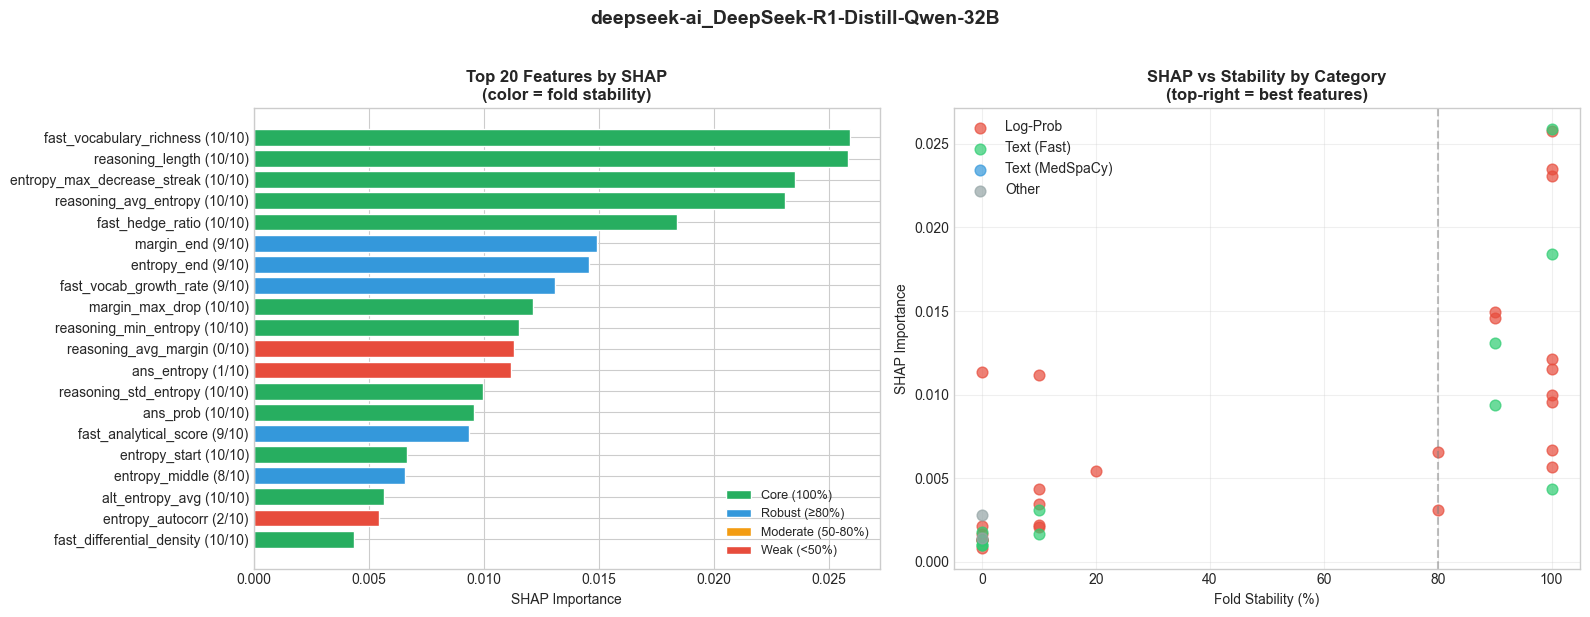


MODEL: openai_gpt-oss-120b

Top 25 Features by SHAP Importance (with Fold Stability):
--------------------------------------------------------------------------------
                    Feature    Category     SHAP Folds Stability
   fast_vocabulary_richness Text (Fast) 0.056073 10/10      100%
           reasoning_length    Log-Prob 0.050677 10/10      100%
      reasoning_std_entropy    Log-Prob 0.033540  0/10        0%
entropy_max_decrease_streak    Log-Prob 0.031028 10/10      100%
                entropy_end    Log-Prob 0.021167  0/10        0%
            alt_entropy_avg    Log-Prob 0.019547 10/10      100%
     fast_vocab_growth_rate Text (Fast) 0.018660  9/10       90%
                 margin_end    Log-Prob 0.018029 10/10      100%
              global_p10_lp    Log-Prob 0.016613 10/10      100%
      fast_question_density Text (Fast) 0.014762 10/10      100%
       reasoning_avg_margin    Log-Prob 0.014658 10/10      100%
             entropy_middle    Log-Prob 0.012800  9/

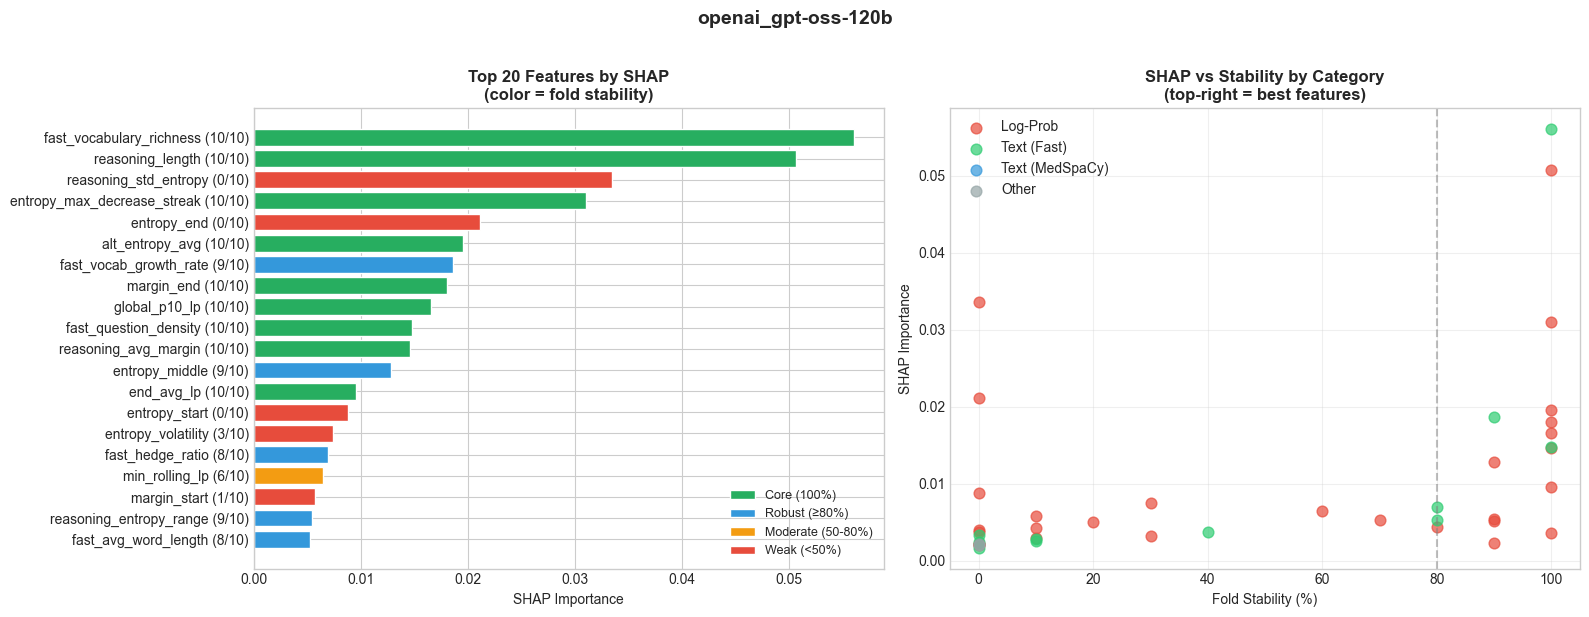

In [78]:
# Unified Feature Analysis: SHAP Importance + Fold Stability
for exp in all_experiments:
    model = exp['model']
    
    # Get SHAP importance
    fi_key = 'feature_importance_shap' if 'feature_importance_shap' in exp else 'feature_importance_model'
    if fi_key not in exp:
        print(f"No feature importance for {model}")
        continue
    fi = exp[fi_key]
    
    # Get fold stability
    if 'feature_selection' not in exp:
        print(f"No feature selection data for {model}")
        continue
    fs = exp['feature_selection']
    n_folds = fs['n_folds']
    stability_map = {f['Feature']: f['Folds'] for f in fs['features']}
    
    # Build unified DataFrame
    rows = []
    for feat, shap_imp in fi.items():
        folds = stability_map.get(feat, 0)
        stability_pct = folds / n_folds * 100
        
        # Determine category
        if feat.startswith('fast_'):
            category = 'Text (Fast)'
        elif feat.startswith('text_'):
            category = 'Text (MedSpaCy)'
        elif any(x in feat for x in ['entropy', 'margin', 'lp', 'ans_', 'reasoning_']):
            category = 'Log-Prob'
        else:
            category = 'Other'
        
        rows.append({
            'Feature': feat,
            'Category': category,
            'SHAP': shap_imp,
            'Folds': folds,
            'Stability': f"{stability_pct:.0f}%",
            'n_folds': n_folds
        })
    
    unified_df = pd.DataFrame(rows).sort_values('SHAP', ascending=False)
    
    # Display table
    print(f"\n{'='*80}")
    print(f"MODEL: {model}")
    print(f"{'='*80}")
    print(f"\nTop 25 Features by SHAP Importance (with Fold Stability):")
    print("-"*80)
    
    display_df = unified_df.head(25)[['Feature', 'Category', 'SHAP', 'Folds', 'Stability']].copy()
    display_df['SHAP'] = display_df['SHAP'].map(lambda x: f"{x:.6f}")
    display_df['Folds'] = display_df['Folds'].map(lambda x: f"{int(x)}/{n_folds}")
    print(display_df.to_string(index=False))
    
    # Summary stats
    core_features = unified_df[unified_df['Folds'] == n_folds]
    robust_features = unified_df[unified_df['Folds'] >= n_folds * 0.8]
    
    print(f"\n📊 Summary:")
    print(f"   Total features: {len(unified_df)}")
    print(f"   Core features (100% stable): {len(core_features)}")
    print(f"   Robust features (≥80% stable): {len(robust_features)}")
    
    # Visualization: Scatter plot SHAP vs Stability
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Bar chart of top features with stability coloring
    ax = axes[0]
    top_df = unified_df.head(20)
    colors = []
    for _, row in top_df.iterrows():
        stability = row['Folds'] / n_folds
        if stability >= 1.0:
            colors.append('#27ae60')  # Green - Core
        elif stability >= 0.8:
            colors.append('#3498db')  # Blue - Robust
        elif stability >= 0.5:
            colors.append('#f39c12')  # Orange - Moderate
        else:
            colors.append('#e74c3c')  # Red - Weak
    
    y_pos = range(len(top_df))
    bars = ax.barh(y_pos, top_df['SHAP'].values, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{row['Feature']} ({int(row['Folds'])}/{n_folds})" for _, row in top_df.iterrows()])
    ax.invert_yaxis()
    ax.set_xlabel('SHAP Importance')
    ax.set_title(f'Top 20 Features by SHAP\n(color = fold stability)', fontsize=12, fontweight='bold')
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#27ae60', label='Core (100%)'),
        Patch(facecolor='#3498db', label='Robust (≥80%)'),
        Patch(facecolor='#f39c12', label='Moderate (50-80%)'),
        Patch(facecolor='#e74c3c', label='Weak (<50%)'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
    
    # Right: Scatter plot SHAP vs Stability by category
    ax = axes[1]
    category_colors = {
        'Log-Prob': '#e74c3c',
        'Text (Fast)': '#2ecc71',
        'Text (MedSpaCy)': '#3498db',
        'Other': '#95a5a6'
    }
    
    for cat in category_colors:
        cat_df = unified_df[unified_df['Category'] == cat]
        ax.scatter(
            cat_df['Folds'] / n_folds * 100,
            cat_df['SHAP'],
            c=category_colors[cat],
            label=cat,
            alpha=0.7,
            s=60
        )
    
    ax.set_xlabel('Fold Stability (%)')
    ax.set_ylabel('SHAP Importance')
    ax.set_title('SHAP vs Stability by Category\n(top-right = best features)', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left')
    ax.axvline(x=80, color='gray', linestyle='--', alpha=0.5, label='80% threshold')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{model}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

---
# 3. Cross-Model Comparison: Overall Performance

**What it shows:** Aggregate performance metrics across all models:
- Average baseline vs filtered accuracy
- Average gain achieved by the RF filter

> Useful to compare which LLM models benefit most from the RF filter

Cross-Model Comparison (Latest Experiments)
                                   model           timestamp avg_baseline avg_filtered avg_gain avg_coverage
deepseek-ai_DeepSeek-R1-Distill-Qwen-32B 2025-11-28_11-15-56        62.8%        70.2%     7.4%        57.1%
                     openai_gpt-oss-120b 2025-11-28_11-31-02        71.8%        77.5%     5.7%        61.3%


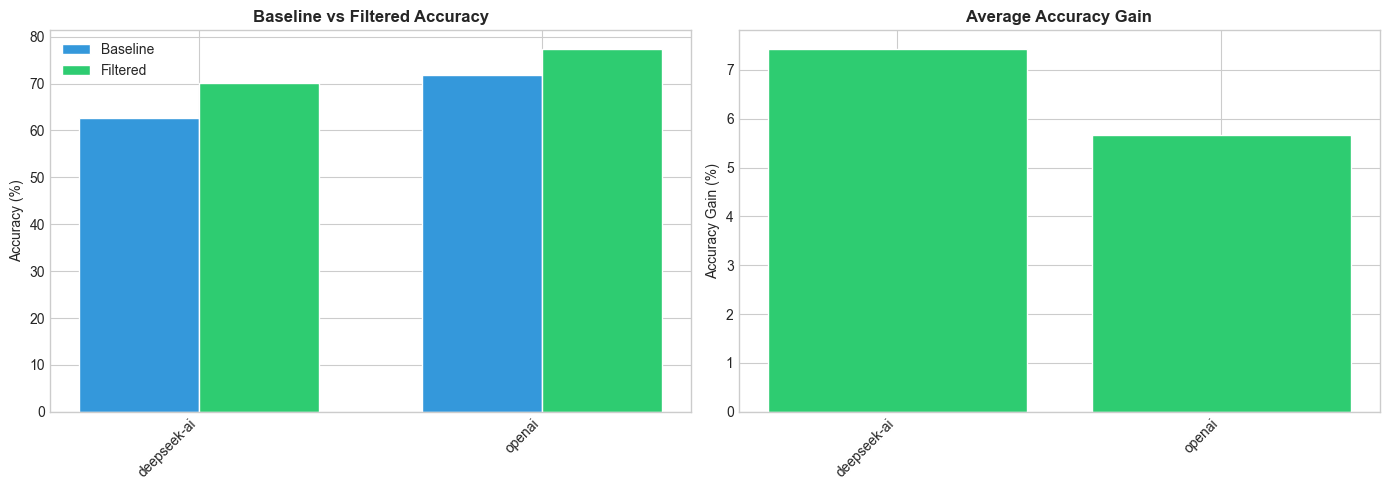

In [79]:
# Compare models
comparison_df = loader.compare_models()

if len(comparison_df) > 0:
    print("Cross-Model Comparison (Latest Experiments)")
    print("="*70)
    
    display_df = comparison_df.copy()
    for col in ['avg_baseline', 'avg_filtered', 'avg_gain', 'avg_coverage']:
        if col in display_df.columns:
            display_df[col] = display_df[col].map(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
    
    print(display_df.to_string(index=False))
    
    # Bar chart
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    models = comparison_df['model'].str.split('_').str[0]  # Short names
    
    # Accuracy comparison
    ax = axes[0]
    x = range(len(models))
    width = 0.35
    ax.bar([i - width/2 for i in x], comparison_df['avg_baseline'] * 100, width, label='Baseline', color='#3498db')
    ax.bar([i + width/2 for i in x], comparison_df['avg_filtered'] * 100, width, label='Filtered', color='#2ecc71')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Baseline vs Filtered Accuracy', fontweight='bold')
    ax.legend()
    
    # Gain comparison
    ax = axes[1]
    colors = ['#2ecc71' if g > 0 else '#e74c3c' for g in comparison_df['avg_gain']]
    ax.bar(x, comparison_df['avg_gain'] * 100, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel('Accuracy Gain (%)')
    ax.set_title('Average Accuracy Gain', fontweight='bold')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("No experiments found. Run training_single_model.ipynb first.")

---
# 4. Coverage vs Accuracy Trade-off

**What it shows:** Scatter plot of coverage vs accuracy for each dataset:
- X-axis: Coverage (% of questions the model responds to)
- Y-axis: Filtered accuracy (accuracy on answered questions)

> Ideal: **top-right** corner (high accuracy + high coverage)

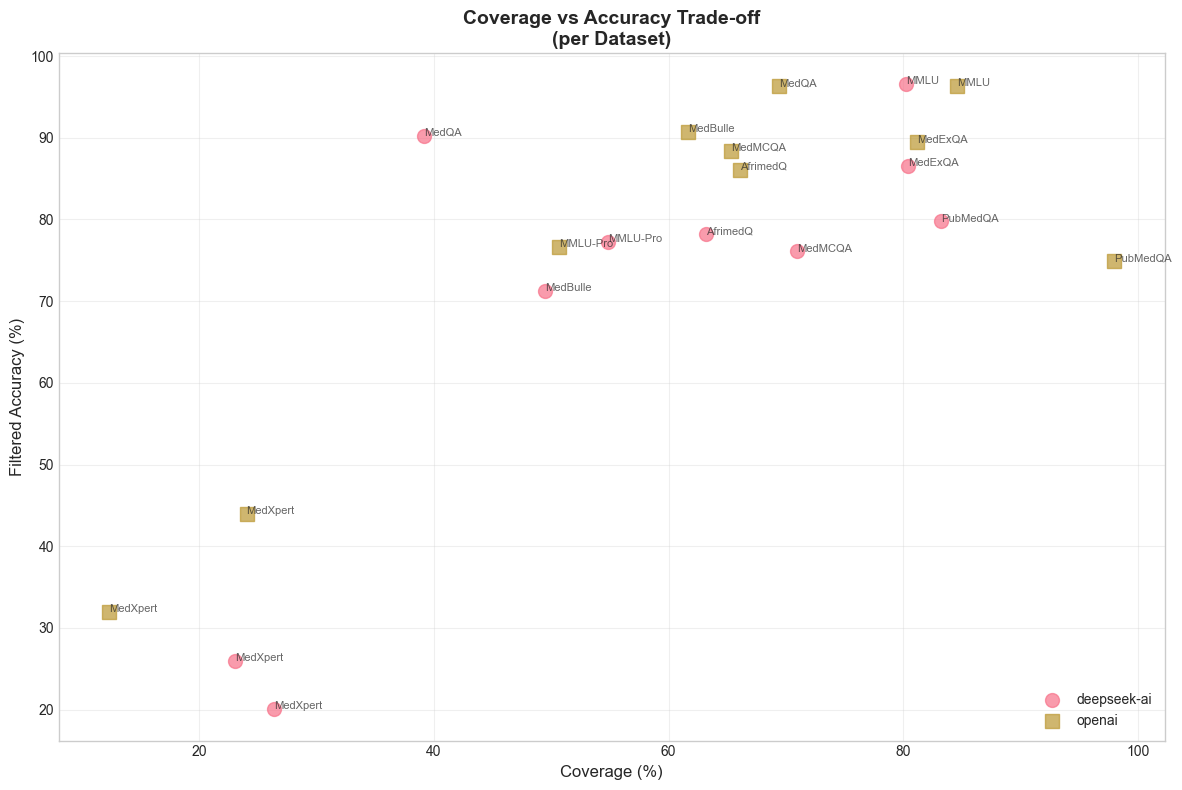

In [80]:
# Scatter plot: Coverage vs Accuracy for each dataset
if len(all_experiments) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    for i, exp in enumerate(all_experiments):
        if 'lodo_results' not in exp:
            continue
        
        model = exp['model'].split('_')[0]  # Short name
        df = pd.DataFrame(exp['lodo_results'])
        
        ax.scatter(
            df['Coverage'] * 100, 
            df['Filtered_Acc'] * 100,
            label=model,
            marker=markers[i % len(markers)],
            s=100,
            alpha=0.7
        )
        
        # Annotate points
        for _, row in df.iterrows():
            ax.annotate(
                row['Dataset'][:8],  # Truncate long names
                (row['Coverage'] * 100, row['Filtered_Acc'] * 100),
                fontsize=8,
                alpha=0.7
            )
    
    ax.set_xlabel('Coverage (%)', fontsize=12)
    ax.set_ylabel('Filtered Accuracy (%)', fontsize=12)
    ax.set_title('Coverage vs Accuracy Trade-off\n(per Dataset)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

---
# 5. Cross-Model Feature Analysis: Generalizing Features

**What it shows:** Which features are important **across ALL models** (not just one):
- **Avg SHAP** = average SHAP importance across all models
- **Models** = in how many models the feature appears (out of total)
- **Model %** = percentage of models where feature is present
- **Avg Fold %** = average fold stability across models

> **Generalizing features** = high Avg SHAP + present in ALL models + high Avg Fold %
> 
> These are the most reliable features for predicting answer correctness regardless of the LLM

CROSS-MODEL FEATURE ANALYSIS (2 models)

Models analyzed: deepseek-ai, openai

──────────────────────────────────────────────────────────────────────────────────────────
GENERALIZING FEATURES (present in ALL 2 models): 35
──────────────────────────────────────────────────────────────────────────────────────────
                    Feature    Category Avg SHAP Models Avg Fold Stability
   fast_vocabulary_richness Text (Fast) 0.040985    2/2               100%
           reasoning_length    Log-Prob 0.038237    2/2               100%
entropy_max_decrease_streak    Log-Prob 0.027271    2/2               100%
      reasoning_std_entropy    Log-Prob 0.021755    2/2                50%
                entropy_end    Log-Prob 0.017863    2/2                45%
                 margin_end    Log-Prob 0.016473    2/2                95%
     fast_vocab_growth_rate Text (Fast) 0.015881    2/2                90%
       reasoning_avg_margin    Log-Prob 0.012993    2/2                50%
           f

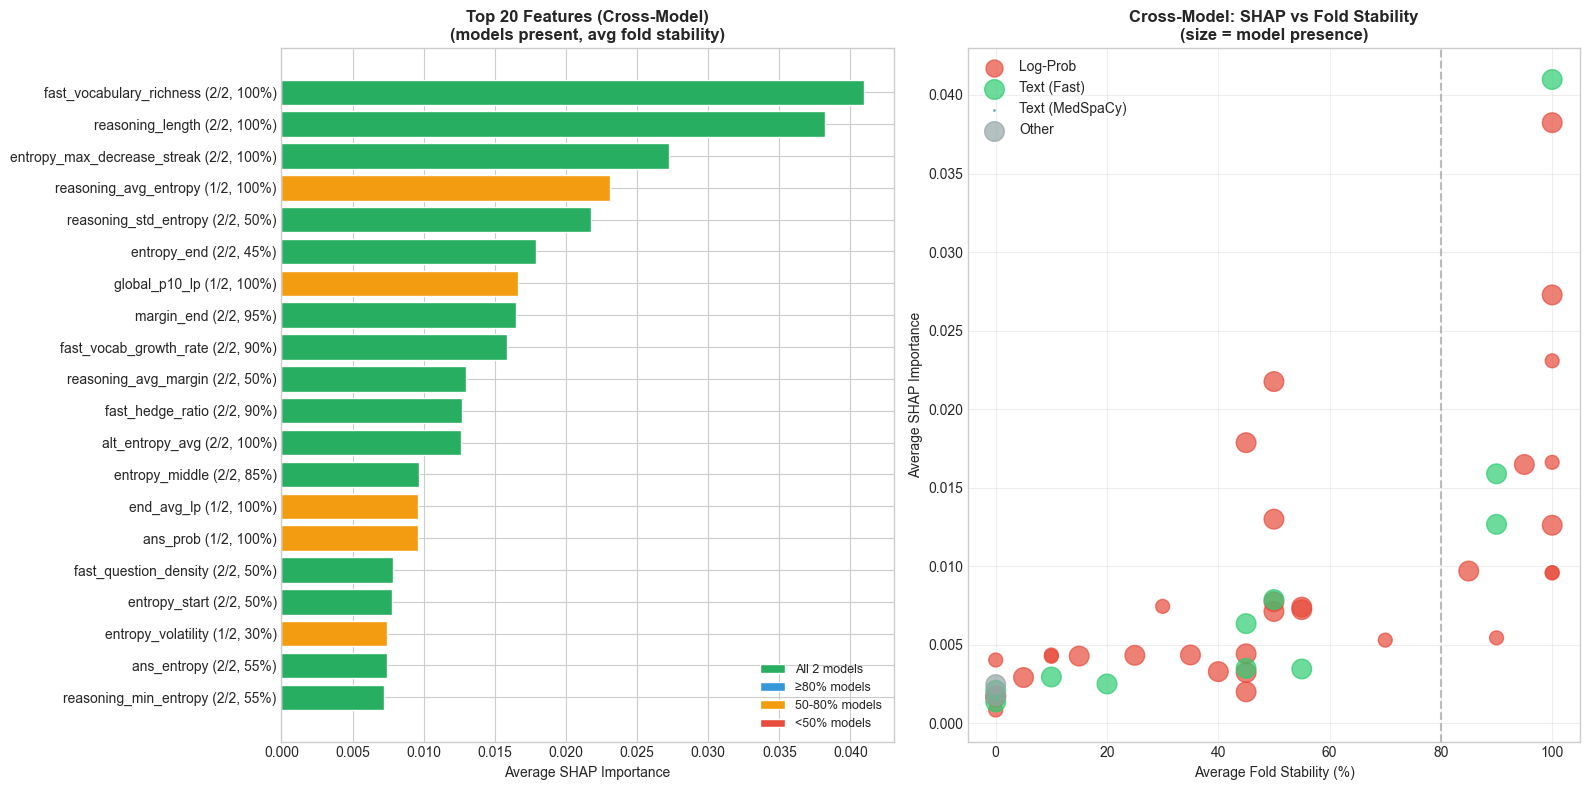

In [81]:
# Cross-Model Feature Analysis: Generalizing Features
if len(all_experiments) >= 1:
    # Collect SHAP importances AND fold stability from all models
    all_importances = {}
    all_stabilities = {}
    models_list = []
    
    for exp in all_experiments:
        fi_key = 'feature_importance_shap' if 'feature_importance_shap' in exp else 'feature_importance_model'
        if fi_key not in exp:
            continue
        
        model = exp['model']
        models_list.append(model)
        fi = exp[fi_key]
        
        # Get fold stability for this model
        n_folds = 1
        stability_map = {}
        if 'feature_selection' in exp:
            fs = exp['feature_selection']
            n_folds = fs['n_folds']
            stability_map = {f['Feature']: f['Folds'] / n_folds for f in fs['features']}
        
        for feat, importance in fi.items():
            if feat not in all_importances:
                all_importances[feat] = {}
                all_stabilities[feat] = {}
            all_importances[feat][model] = importance
            all_stabilities[feat][model] = stability_map.get(feat, 0)
    
    n_models = len(models_list)
    
    if n_models >= 1:
        # Build cross-model DataFrame
        rows = []
        for feat in all_importances:
            shap_values = list(all_importances[feat].values())
            stability_values = list(all_stabilities[feat].values())
            models_present = len(shap_values)
            
            # Determine category
            if feat.startswith('fast_'):
                category = 'Text (Fast)'
            elif feat.startswith('text_'):
                category = 'Text (MedSpaCy)'
            elif any(x in feat for x in ['entropy', 'margin', 'lp', 'ans_', 'reasoning_']):
                category = 'Log-Prob'
            else:
                category = 'Other'
            
            rows.append({
                'Feature': feat,
                'Category': category,
                'Avg_SHAP': sum(shap_values) / len(shap_values),
                'Models': models_present,
                'Model_Pct': models_present / n_models * 100,
                'Avg_Fold_Pct': sum(stability_values) / len(stability_values) * 100 if stability_values else 0,
            })
        
        cross_df = pd.DataFrame(rows).sort_values('Avg_SHAP', ascending=False)
        
        # Display summary table
        print("="*90)
        print(f"CROSS-MODEL FEATURE ANALYSIS ({n_models} models)")
        print("="*90)
        print(f"\nModels analyzed: {', '.join([m.split('_')[0] for m in models_list])}")
        
        # Features present in ALL models
        core_cross = cross_df[cross_df['Models'] == n_models]
        print(f"\n{'─'*90}")
        print(f"GENERALIZING FEATURES (present in ALL {n_models} models): {len(core_cross)}")
        print(f"{'─'*90}")
        
        if len(core_cross) > 0:
            display_core = core_cross.head(30)[['Feature', 'Category', 'Avg_SHAP', 'Models', 'Avg_Fold_Pct']].copy()
            display_core['Avg_SHAP'] = display_core['Avg_SHAP'].map(lambda x: f"{x:.6f}")
            display_core['Models'] = display_core['Models'].map(lambda x: f"{int(x)}/{n_models}")
            display_core['Avg_Fold_Pct'] = display_core['Avg_Fold_Pct'].map(lambda x: f"{x:.0f}%")
            display_core.columns = ['Feature', 'Category', 'Avg SHAP', 'Models', 'Avg Fold Stability']
            print(display_core.to_string(index=False))
        else:
            print("   No features present in all models")
        
        # Features in most models (>=80%)
        robust_cross = cross_df[(cross_df['Model_Pct'] >= 80) & (cross_df['Model_Pct'] < 100)]
        if len(robust_cross) > 0:
            print(f"\n{'─'*90}")
            print(f"ROBUST FEATURES (present in ≥80% models): {len(robust_cross)}")
            print(f"{'─'*90}")
            display_robust = robust_cross.head(15)[['Feature', 'Category', 'Avg_SHAP', 'Models', 'Avg_Fold_Pct']].copy()
            display_robust['Avg_SHAP'] = display_robust['Avg_SHAP'].map(lambda x: f"{x:.6f}")
            display_robust['Models'] = display_robust['Models'].map(lambda x: f"{int(x)}/{n_models}")
            display_robust['Avg_Fold_Pct'] = display_robust['Avg_Fold_Pct'].map(lambda x: f"{x:.0f}%")
            display_robust.columns = ['Feature', 'Category', 'Avg SHAP', 'Models', 'Avg Fold Stability']
            print(display_robust.to_string(index=False))
        
        # Summary by category
        print(f"\n{'─'*90}")
        print("SUMMARY BY CATEGORY (generalizing features only)")
        print(f"{'─'*90}")
        if len(core_cross) > 0:
            cat_summary = core_cross.groupby('Category').agg({
                'Feature': 'count',
                'Avg_SHAP': 'mean',
                'Avg_Fold_Pct': 'mean'
            }).sort_values('Avg_SHAP', ascending=False)
            cat_summary.columns = ['Count', 'Avg SHAP', 'Avg Fold %']
            print(cat_summary.to_string())
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Left: Top features bar chart
        ax = axes[0]
        top_cross = cross_df.head(20)
        
        # Color by model presence
        colors = []
        for _, row in top_cross.iterrows():
            if row['Model_Pct'] >= 100:
                colors.append('#27ae60')  # Green - All models
            elif row['Model_Pct'] >= 80:
                colors.append('#3498db')  # Blue - Most models
            elif row['Model_Pct'] >= 50:
                colors.append('#f39c12')  # Orange - Some models
            else:
                colors.append('#e74c3c')  # Red - Few models
        
        y_pos = range(len(top_cross))
        ax.barh(y_pos, top_cross['Avg_SHAP'].values, color=colors)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([
            f"{row['Feature']} ({int(row['Models'])}/{n_models}, {row['Avg_Fold_Pct']:.0f}%)" 
            for _, row in top_cross.iterrows()
        ])
        ax.invert_yaxis()
        ax.set_xlabel('Average SHAP Importance')
        ax.set_title('Top 20 Features (Cross-Model)\n(models present, avg fold stability)', fontsize=12, fontweight='bold')
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#27ae60', label=f'All {n_models} models'),
            Patch(facecolor='#3498db', label='≥80% models'),
            Patch(facecolor='#f39c12', label='50-80% models'),
            Patch(facecolor='#e74c3c', label='<50% models'),
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
        
        # Right: Scatter by category
        ax = axes[1]
        category_colors = {
            'Log-Prob': '#e74c3c',
            'Text (Fast)': '#2ecc71',
            'Text (MedSpaCy)': '#3498db',
            'Other': '#95a5a6'
        }
        
        for cat in category_colors:
            cat_df = cross_df[cross_df['Category'] == cat]
            ax.scatter(
                cat_df['Avg_Fold_Pct'],
                cat_df['Avg_SHAP'],
                c=category_colors[cat],
                label=cat,
                alpha=0.7,
                s=cat_df['Model_Pct'] * 2  # Size by model presence
            )
        
        ax.set_xlabel('Average Fold Stability (%)')
        ax.set_ylabel('Average SHAP Importance')
        ax.set_title('Cross-Model: SHAP vs Fold Stability\n(size = model presence)', fontsize=12, fontweight='bold')
        ax.legend(loc='upper left')
        ax.axvline(x=80, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
else:
    print("Need at least 1 model for analysis. Run training_single_model.ipynb first.")

---
# 6. Calibration Analysis: LLM vs RF Classifier

**What is Calibration?**
> When a model says "80% confident", it should be correct ~80% of the time.
> A well-calibrated model's confidence matches its actual accuracy.

**Expected Calibration Error (ECE)**
> ECE measures the gap between predicted confidence and actual accuracy across bins.
> **Lower ECE = Better Calibration**

**What we compare:**
- **LLM Raw Confidence** (`ans_prob`): The probability the LLM assigned to its chosen answer
- **RF Classifier Confidence** (`rf_prob`): The probability from our trained Random Forest

> If RF has lower ECE than LLM, our classifier **improves calibration** beyond raw model confidence!

In [ ]:
import numpy as np
from matplotlib.patches import FancyBboxPatch
import matplotlib.gridspec as gridspec

def compute_calibration_metrics(y_true, y_prob, n_bins=10):
    """
    Compute calibration metrics: ECE, MCE, and per-bin statistics.
    
    Args:
        y_true: Ground truth labels (0 or 1)
        y_prob: Predicted probabilities
        n_bins: Number of bins for calibration
        
    Returns:
        dict with ECE, MCE, and bin statistics
    """
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    
    # Create bins
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bin_boundaries[1:-1])
    
    bin_stats = []
    ece = 0.0
    mce = 0.0
    
    for i in range(n_bins):
        mask = bin_indices == i
        bin_size = mask.sum()
        
        if bin_size > 0:
            bin_accuracy = y_true[mask].mean()
            bin_confidence = y_prob[mask].mean()
            bin_gap = abs(bin_accuracy - bin_confidence)
            
            # Weighted contribution to ECE
            ece += (bin_size / len(y_true)) * bin_gap
            mce = max(mce, bin_gap)
            
            bin_stats.append({
                'bin_idx': i,
                'bin_lower': bin_boundaries[i],
                'bin_upper': bin_boundaries[i + 1],
                'bin_mid': (bin_boundaries[i] + bin_boundaries[i + 1]) / 2,
                'count': bin_size,
                'accuracy': bin_accuracy,
                'confidence': bin_confidence,
                'gap': bin_gap,
            })
        else:
            bin_stats.append({
                'bin_idx': i,
                'bin_lower': bin_boundaries[i],
                'bin_upper': bin_boundaries[i + 1],
                'bin_mid': (bin_boundaries[i] + bin_boundaries[i + 1]) / 2,
                'count': 0,
                'accuracy': None,
                'confidence': None,
                'gap': None,
            })
    
    return {
        'ece': ece,
        'mce': mce,
        'n_samples': len(y_true),
        'bins': bin_stats,
    }


def plot_calibration_comparison(predictions_df, model_name, n_bins=10):
    """
    Create a comprehensive calibration comparison visualization.
    """
    y_true = predictions_df['y_true'].values
    llm_prob = predictions_df['ans_prob'].values
    rf_prob = predictions_df['rf_prob'].values
    
    # Compute calibration metrics
    llm_cal = compute_calibration_metrics(y_true, llm_prob, n_bins)
    rf_cal = compute_calibration_metrics(y_true, rf_prob, n_bins)
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1.2, 1], width_ratios=[1, 1, 0.8],
                           hspace=0.3, wspace=0.3)
    
    # ==========================================================================
    # TOP LEFT: Reliability Diagram - LLM
    # ==========================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    llm_bins = [b for b in llm_cal['bins'] if b['count'] > 0]
    bin_mids = [b['bin_mid'] for b in llm_bins]
    accuracies = [b['accuracy'] for b in llm_bins]
    counts = [b['count'] for b in llm_bins]
    
    # Perfect calibration line
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration', alpha=0.7)
    
    # Bar chart for accuracy
    bar_width = 0.08
    bars = ax1.bar(bin_mids, accuracies, width=bar_width, alpha=0.7, 
                   color='#e74c3c', edgecolor='darkred', linewidth=1.5,
                   label=f'LLM (ECE={llm_cal["ece"]:.3f})')
    
    # Add gap visualization
    for b in llm_bins:
        if b['gap'] and b['gap'] > 0.02:
            ax1.fill_between([b['bin_mid'] - bar_width/2, b['bin_mid'] + bar_width/2],
                            [min(b['accuracy'], b['confidence'])] * 2,
                            [max(b['accuracy'], b['confidence'])] * 2,
                            alpha=0.3, color='red', hatch='///')
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Mean Predicted Probability (Confidence)', fontsize=11)
    ax1.set_ylabel('Fraction of Positives (Accuracy)', fontsize=11)
    ax1.set_title('LLM Raw Confidence\n(ans_prob)', fontsize=13, fontweight='bold', color='#e74c3c')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # ==========================================================================
    # TOP MIDDLE: Reliability Diagram - RF
    # ==========================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    rf_bins = [b for b in rf_cal['bins'] if b['count'] > 0]
    bin_mids_rf = [b['bin_mid'] for b in rf_bins]
    accuracies_rf = [b['accuracy'] for b in rf_bins]
    
    # Perfect calibration line
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration', alpha=0.7)
    
    # Bar chart for accuracy
    bars_rf = ax2.bar(bin_mids_rf, accuracies_rf, width=bar_width, alpha=0.7,
                      color='#27ae60', edgecolor='darkgreen', linewidth=1.5,
                      label=f'RF Classifier (ECE={rf_cal["ece"]:.3f})')
    
    # Add gap visualization
    for b in rf_bins:
        if b['gap'] and b['gap'] > 0.02:
            ax2.fill_between([b['bin_mid'] - bar_width/2, b['bin_mid'] + bar_width/2],
                            [min(b['accuracy'], b['confidence'])] * 2,
                            [max(b['accuracy'], b['confidence'])] * 2,
                            alpha=0.3, color='green', hatch='///')
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel('Mean Predicted Probability (Confidence)', fontsize=11)
    ax2.set_ylabel('Fraction of Positives (Accuracy)', fontsize=11)
    ax2.set_title('RF Classifier Confidence\n(rf_prob)', fontsize=13, fontweight='bold', color='#27ae60')
    ax2.legend(loc='upper left', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    # ==========================================================================
    # TOP RIGHT: ECE Comparison Summary
    # ==========================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    
    # Create summary box
    ece_improvement = llm_cal['ece'] - rf_cal['ece']
    ece_improvement_pct = (ece_improvement / llm_cal['ece']) * 100 if llm_cal['ece'] > 0 else 0
    
    summary_text = f"""
╔══════════════════════════════╗
║   CALIBRATION COMPARISON     ║
╠══════════════════════════════╣
║                              ║
║  LLM (ans_prob)              ║
║  ─────────────────           ║
║  ECE:  {llm_cal['ece']:.4f}               ║
║  MCE:  {llm_cal['mce']:.4f}               ║
║                              ║
║  RF Classifier               ║
║  ─────────────────           ║
║  ECE:  {rf_cal['ece']:.4f}               ║
║  MCE:  {rf_cal['mce']:.4f}               ║
║                              ║
╠══════════════════════════════╣
║  IMPROVEMENT                 ║
║  ─────────────────           ║
║  ΔECE: {ece_improvement:+.4f}              ║
║        ({ece_improvement_pct:+.1f}%)               ║
║                              ║
║  Samples: {llm_cal['n_samples']:,}            ║
╚══════════════════════════════╝
"""
    
    # Color based on improvement
    box_color = '#d4edda' if ece_improvement > 0 else '#f8d7da'
    
    ax3.text(0.5, 0.5, summary_text, transform=ax3.transAxes,
             fontsize=11, fontfamily='monospace',
             verticalalignment='center', horizontalalignment='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor=box_color, edgecolor='gray', alpha=0.9))
    
    # Add verdict
    if ece_improvement > 0:
        verdict = "✓ RF IMPROVES CALIBRATION"
        verdict_color = '#155724'
    else:
        verdict = "✗ LLM BETTER CALIBRATED"
        verdict_color = '#721c24'
    
    ax3.text(0.5, 0.02, verdict, transform=ax3.transAxes,
             fontsize=14, fontweight='bold', color=verdict_color,
             verticalalignment='bottom', horizontalalignment='center')
    
    # ==========================================================================
    # BOTTOM LEFT: Histogram of Confidences
    # ==========================================================================
    ax4 = fig.add_subplot(gs[1, 0])
    
    bins_hist = np.linspace(0, 1, 21)
    ax4.hist(llm_prob, bins=bins_hist, alpha=0.6, color='#e74c3c', 
             label='LLM (ans_prob)', edgecolor='darkred', density=True)
    ax4.hist(rf_prob, bins=bins_hist, alpha=0.6, color='#27ae60',
             label='RF (rf_prob)', edgecolor='darkgreen', density=True)
    
    ax4.set_xlabel('Predicted Probability', fontsize=11)
    ax4.set_ylabel('Density', fontsize=11)
    ax4.set_title('Distribution of Confidence Scores', fontsize=13, fontweight='bold')
    ax4.legend(loc='upper left', fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    # ==========================================================================
    # BOTTOM MIDDLE: Gap Analysis (Bar Chart)
    # ==========================================================================
    ax5 = fig.add_subplot(gs[1, 1])
    
    # Prepare data for gap comparison
    bin_labels = [f'{b["bin_lower"]:.1f}-{b["bin_upper"]:.1f}' for b in llm_cal['bins']]
    llm_gaps = [b['gap'] if b['gap'] is not None else 0 for b in llm_cal['bins']]
    rf_gaps = [b['gap'] if b['gap'] is not None else 0 for b in rf_cal['bins']]
    
    x = np.arange(len(bin_labels))
    width = 0.35
    
    bars1 = ax5.bar(x - width/2, llm_gaps, width, label='LLM Gap', color='#e74c3c', alpha=0.7)
    bars2 = ax5.bar(x + width/2, rf_gaps, width, label='RF Gap', color='#27ae60', alpha=0.7)
    
    ax5.set_xlabel('Confidence Bin', fontsize=11)
    ax5.set_ylabel('Calibration Gap |Acc - Conf|', fontsize=11)
    ax5.set_title('Per-Bin Calibration Gap', fontsize=13, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=9)
    ax5.legend(loc='upper right', fontsize=10)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # ==========================================================================
    # BOTTOM RIGHT: Calibration by Dataset
    # ==========================================================================
    ax6 = fig.add_subplot(gs[1, 2])
    
    # Compute ECE per dataset
    datasets = predictions_df['dataset'].unique()
    dataset_ece = []
    
    for ds in datasets:
        ds_mask = predictions_df['dataset'] == ds
        ds_preds = predictions_df[ds_mask]
        
        llm_ece_ds = compute_calibration_metrics(ds_preds['y_true'].values, 
                                                   ds_preds['ans_prob'].values, n_bins=5)['ece']
        rf_ece_ds = compute_calibration_metrics(ds_preds['y_true'].values,
                                                  ds_preds['rf_prob'].values, n_bins=5)['ece']
        
        dataset_ece.append({
            'dataset': ds[:10],  # Truncate name
            'llm_ece': llm_ece_ds,
            'rf_ece': rf_ece_ds,
            'improvement': llm_ece_ds - rf_ece_ds,
        })
    
    ds_df = pd.DataFrame(dataset_ece).sort_values('improvement', ascending=True)
    
    colors = ['#27ae60' if imp > 0 else '#e74c3c' for imp in ds_df['improvement']]
    y_pos = range(len(ds_df))
    
    ax6.barh(y_pos, ds_df['improvement'], color=colors, alpha=0.7, edgecolor='gray')
    ax6.set_yticks(y_pos)
    ax6.set_yticklabels(ds_df['dataset'], fontsize=9)
    ax6.axvline(x=0, color='black', linewidth=1)
    ax6.set_xlabel('ECE Improvement (LLM - RF)', fontsize=10)
    ax6.set_title('Per-Dataset\nCalibration Δ', fontsize=11, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    
    # Add annotation
    ax6.text(0.95, 0.05, '← RF better | LLM better →', transform=ax6.transAxes,
             fontsize=8, alpha=0.6, ha='right', va='bottom')
    
    # Main title
    fig.suptitle(f'Calibration Analysis: {model_name}',
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return llm_cal, rf_cal


# =============================================================================
# RUN CALIBRATION ANALYSIS FOR EACH MODEL
# =============================================================================
print("="*90)
print("CALIBRATION ANALYSIS: LLM vs RF Classifier")
print("="*90)

for exp in all_experiments:
    model = exp['model']
    
    if 'predictions' not in exp:
        print(f"\n⚠️  No predictions found for {model}")
        print("   Run training_single_model.ipynb to generate predictions.json")
        continue
    
    predictions_df = pd.DataFrame(exp['predictions'])
    
    print(f"\n{'─'*90}")
    print(f"Model: {model}")
    print(f"Samples: {len(predictions_df):,}")
    print(f"{'─'*90}")
    
    # Generate visualization
    llm_cal, rf_cal = plot_calibration_comparison(predictions_df, model)
    
    # Print detailed table
    print(f"\nDetailed Bin Statistics:")
    print(f"{'Bin':<12} {'LLM Acc':>10} {'LLM Conf':>10} {'LLM Gap':>10} │ {'RF Acc':>10} {'RF Conf':>10} {'RF Gap':>10} │ {'Count':>8}")
    print("─" * 95)
    
    for llm_b, rf_b in zip(llm_cal['bins'], rf_cal['bins']):
        bin_label = f"{llm_b['bin_lower']:.1f}-{llm_b['bin_upper']:.1f}"
        
        llm_acc = f"{llm_b['accuracy']:.3f}" if llm_b['accuracy'] is not None else "   -   "
        llm_conf = f"{llm_b['confidence']:.3f}" if llm_b['confidence'] is not None else "   -   "
        llm_gap = f"{llm_b['gap']:.3f}" if llm_b['gap'] is not None else "   -   "
        
        rf_acc = f"{rf_b['accuracy']:.3f}" if rf_b['accuracy'] is not None else "   -   "
        rf_conf = f"{rf_b['confidence']:.3f}" if rf_b['confidence'] is not None else "   -   "
        rf_gap = f"{rf_b['gap']:.3f}" if rf_b['gap'] is not None else "   -   "
        
        count = llm_b['count']
        
        print(f"{bin_label:<12} {llm_acc:>10} {llm_conf:>10} {llm_gap:>10} │ {rf_acc:>10} {rf_conf:>10} {rf_gap:>10} │ {count:>8,}")
    
    print("─" * 95)
    print(f"{'TOTAL ECE':<12} {' '*10} {' '*10} {llm_cal['ece']:>10.4f} │ {' '*10} {' '*10} {rf_cal['ece']:>10.4f} │ {llm_cal['n_samples']:>8,}")
    
    # Summary
    ece_improvement = llm_cal['ece'] - rf_cal['ece']
    ece_pct = (ece_improvement / llm_cal['ece']) * 100 if llm_cal['ece'] > 0 else 0
    
    print(f"\n{'='*90}")
    if ece_improvement > 0:
        print(f"✅ RF CLASSIFIER IMPROVES CALIBRATION BY {ece_improvement:.4f} ({ece_pct:.1f}% reduction in ECE)")
    else:
        print(f"⚠️  LLM raw confidence is better calibrated (Δ={ece_improvement:.4f})")
    print(f"{'='*90}")